In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d6d8ae7a20>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1d6d8b2b4e0>,
 'elevation': 3.0,
 'id': 1,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Climate Analysis

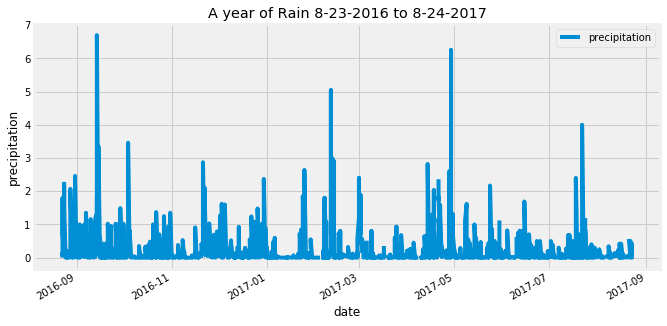

In [53]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_dt = datetime.strptime(last_date[0], '%Y-%m-%d')
year_ago = last_dt - dt.timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores
year_of_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago.strftime("%Y-%m-%d")).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(year_of_data, columns=['date', 'precipitation'])
df["date object"] = ""
for index in range(len(df['date'])):
    df.iloc[index, 2] = datetime.strptime(df.iloc[index, 0], '%Y-%m-%d')
df.drop(['date'],axis=1,inplace=True)
df.set_index("date object", inplace=True)

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10,5), grid=True)
plt.xlabel("date")
plt.ylabel("precipitation")
plt.title("A year of Rain 8-23-2016 to 8-24-2017")
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {num_stations} weather stations in the dataset")

There are 9 weather stations in the dataset


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
each_station = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
print(f" Station {each_station[0][0]} has the most measurements")
each_station

 Station USC00519281 has the most measurements


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lo_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == each_station[0][0]).\
    order_by(Measurement.tobs).first()
hi_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == each_station[0][0]).\
    order_by(Measurement.tobs.desc()).first()
av_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == each_station[0][0]).\
    order_by(Measurement.tobs.desc()).first()
print(f"The Lowest temperature recorded at station {each_station[0][0]} was {lo_temp[0]}")
print(f"The Highest temperature recorded at station {each_station[0][0]} was {hi_temp[0]}")
print(f"The Average temperature recorded at station {each_station[0][0]} was {av_temp[0]}")

The Lowest temperature recorded at station USC00519281 was 54.0
The Highest temperature recorded at station USC00519281 was 85.0
The Average temperature recorded at station USC00519281 was 71.66378066378067


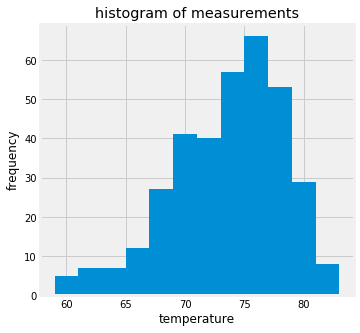

In [52]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_of_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == each_station[0][0]).\
    filter(Measurement.date > year_ago.strftime("%Y-%m-%d")).all()
df_temp = pd.DataFrame(year_of_temp, columns=['temperature'])

df_temp.hist(bins=12, figsize=(5,5))
plt.xlabel("temperature")
plt.ylabel("frequency")
plt.title("histogram of measurements")
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


## My planned trip dates: 2/22 - 2/28

In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_summary = calc_temps('2017-02-22', '2017-02-28')
print(f"The min temp = {temp_summary[0][0]}")
print(f"The ave temp = {temp_summary[0][1]}")      
print(f"The max temp = {temp_summary[0][2]}")

The min temp = 61.0
The ave temp = 69.8
The max temp = 77.0


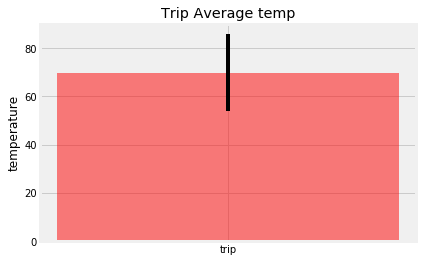

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = temp_summary[0][2]-temp_summary[0][0]
plt.bar('trip', temp_summary[0][1], yerr=error, color='r', alpha=0.5, align="center")
plt.title("Trip Average temp")
plt.ylabel("temperature")
plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-02-22'
end_date = '2017-02-28'
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, func.sum(Measurement.prcp)]
trip_rain = session.query(*sel).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        filter(Measurement.station == Station.station).\
        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
df_trip = pd.DataFrame(trip_rain, columns=['station', 'name', 'lat', 'long', 'total precip'])
df_trip

,station,name,lat,long,total precip
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,1.02
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,0.22
2,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,0.17
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,0.15
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,0.13
5,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,0.10
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.10


## Optional Challenge Assignment

In [54]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
